# Imports

In [3]:
import numpy as np # Lida com arrays
import random      # Gera valores  aleatórios
import timeit      # Marca o tempo
import matplotlib.pyplot as plt # Gera os gráficos
from tqdm import tqdm           # Barra de progresso para o código

# Bibliotecas para utilizar o Spark
import findspark                     # Encontra o Spark
from pyspark.sql import SparkSession # Inicia a sessão do Spark
findspark.init()

# Load fasta

In [5]:
# Local do arquivo
path = 'D:\Ivan\Downloads\human_cov2020_sequences.aln.fasta'

# Abre o arquivo e lê
raw = open(path).read()
# Visualização parcial
raw[:100]

'>hCoV-19/USA/WA-S88/2020|EPI_ISL_417141|2020-03-01\n-------------------------------------------------'

In [6]:
# Separa as amostras do arquivo usando o '>'
# como identificador de início de sequência
file = raw.split('>')
# O split gera elementos vazios na lista,
# por isso precisamos removê-los
# Remove vazios
file = [ x for x in file if x]
# Agora separamos cada sequência do seu identificador,
# utilizando o '\n' como guia
file = np.array([x.split('\n', 1) for x in file])
# O resultado dos passos anteriores gera listas dentro de
# listas, por isso precisamos remove as listas aninhadas
file = file.flatten()
# Agora removemos as quebras de linhas de dentro 
# das sequências
file = [x.replace('\n', '') for x in file]
# Como o resultado é uma lista contendo o cabeçalho da
# seguido da sequência de maneira intercalada
# utilizamos isso para criar listas separadas de
# cabeçalhos e sequências
seqList = np.array([ file[idx] for idx in range(len(file)) if idx%2!=0])
seqList[0][:10]

'----------'

In [7]:
# Transformando a string da seqência em uma lista
seqList = [list(x) for x in seqList]
# Removendo sequências com tamanho errado
tam = max(len(l) for l in seqList)
seqList = [ sub for sub in seqList if len(sub) == tam]
# Transformando em matriz
seqList = np.array(seqList)

# Contagem usando CPU

In [8]:
AMNO = list('ARNDCQEGHILKMFPOSUTWYVBZXJ')
NUCL = list('ATCG')

def countPos(mtrx):
    """
        Conta o número de mutações
    """
    columns = mtrx.shape[0]
    resp = []
    for ii in range(columns):
        resp.append(np.char.count("".join(mtrx[:,ii]), AMNO))

    return resp

# Marca o inicio do processo
start = timeit.default_timer()

# Conta as mutações
finalCPU = countPos(seqList)

# Marca o fim do processo
stop = timeit.default_timer()
# Mostra o resultado
print(f'CPU\nTempo de execução: {stop - start:.5f}s')

CPU
Tempo de execução: 0.50771s


# Contagem com o Spark

In [9]:
# Marca o inicio do processo
start = timeit.default_timer()

# Inicializar  o Spark
spark:SparkSession = SparkSession.builder \
    .master("local[*]") \
    .appName("Conta_Mutacoes") \
    .getOrCreate()

# 1 - np.transpose é utilizado para inverter as posições das
# colunas e das linhas
# 2 - parallelize distribui os processos entre os recursos
# disponíveis, nesse exemplo núcleos do processador
# 3 - map, aplica uma função para cada subdivisão passada pelo RDD
# 4 - Lambda, recebe a função que faz a contagem dos caracteres

rdd = spark.sparkContext.parallelize(np.transpose(seqList))\
      .map(lambda x: np.char.count("".join(x), AMNO))

# Armazena o resultado gerado pelo Spark
finalSpark = rdd.collect()

# Finaliza o processod o Spark
spark.stop()
# Marca o fim do processo
stop = timeit.default_timer()
# Mostra o resultado
print(f'Spark\nTempo de execução: {stop - start:.5f}s')

Spark
Tempo de execução: 7.40283s


# Demonstração do tempo de execução

### Criando sequências artificias ( Testes )

In [9]:
# Lista de aminoácidos e nucleotídeos
AMNO = list('ARNDCQEGHILKMFPOSUTWYVBZXJ')
NUCL = list('ATCG')

def save(name, seqSize, tempList):
    
    file = open(name,'w')
    for idx, ii in enumerate(seqSize):
        file.write(f'{ii},{tempList[idx]}\n')

    file.close()

def countPos(nucleotides, mtrx):
    """
        Conta o número de mutações
    """
    _, columns = mtrx.shape
    resp = []
    for ii in range(columns):
        resp.append(np.char.count("".join(mtrx[:,ii]), nucleotides))

    return resp

def buildSeq(nucleotides, size=10):
    """
        Constrói uma sequência com um tamanho determinado
    """
    aux = ''
    for _ in range(size):
        aux = aux + random.choice(nucleotides)
        
    return np.array(list(aux))

def buildMut(seq, nucleotides):
    """
        Cria cópias da sequência de entrada com pequenas mutações
    """
    aux = list(seq)
    for idx, ii in enumerate(aux):
        if random.random() <= .12:
            aux[idx] = random.choice(nucleotides)
            
    return np.array(aux)

def baseMatrix(seq, nucleotides, n=10):
    """
        Pega a a sequência de entrada, cria as outras sequências
        e armazena tudo em uma matriz
    """
    
    aux = [seq]
    
    for _ in range(n):
        aux.append(buildMut(seq, nucleotides))
    
    return np.array(aux)

def autoTestCPU(mtrx, nucleotides, rep = 10):
    """
        Automatização para os testes tradicionais
    """
    tempList = []
    seqTList = []
    
    for i in tqdm(range(rep)):
        try:
            # Marca o inicio do processo
            start = timeit.default_timer()

            dataArt = mtrx[:, :100*(i+1)]

            # Conta
            finalCPU = countPos(nucleotides, dataArt)
            # Marca o fim do processo
            stop = timeit.default_timer()
            # Mostra o resultado
            cpuT = stop - start
            tempList.append(cpuT)
            seqTList.append(dataArt.shape[1])
        except:
            break
            
    return seqTList, tempList, finalCPU

def autoTestSpr(mtrx, nucleotides, rep = 10):
    """
        Automatização para os testes Spark
    """
    tempList = []
    seqTList = []
    
    for i in tqdm(range(rep)):
        try:
            dataArt = mtrx[:, :100*(i+1)]

            # Marca o inicio do processo
            start = timeit.default_timer()
            # Inicializar  o Spark
            spark:SparkSession = SparkSession.builder \
                .master("local[*]") \
                .appName("Conta_Mutacoes") \
                .config("spark.executor.memory", '15g') \
                .config("spark.driver.memory", '15g') \
                .getOrCreate()

            # 1 - np.transpose é utilizado para inverter as posições das colunas e das linhas
            # 2 - parallelize distribui os processos entre os recursos disponíveis, nesse exemplo
            #     núcleos do processador
            # 3 - map, aplica uma função para cada subdivisão passada pelo RDD
            # 4 - Lambda, recebe a função que faz a contagem dos caracteres

            rdd = spark.sparkContext.parallelize(np.transpose(dataArt))\
                    .map(lambda x: np.char.count("".join(x), nucleotides))

            # Armazena o resultado gerado pelo Spark
            finalSpark = rdd.collect()

            # Finaliza o processod o Spark
            spark.stop()
            # Marca o fim do processo
            stop = timeit.default_timer()
            # Mostra o resultado
            spkT = stop - start
            tempList.append(spkT)
            seqTList.append(dataArt.shape[1])
        except:
            break
            
    return seqTList, tempList#, finalSpark


In [10]:
# Cria matriz artificial para teste

# Cria a matriz de sequências 
rep = 500           # Multiplicador do tamanho final de cada amostra
seqTam = 100*rep     # 5000
masterSeq = buildSeq(NUCL, seqTam) # Contstrói sequência 'mãe'
# Número total de seuqências
repetitions = 5000  # 5000
dataArt = baseMatrix(masterSeq, NUCL, repetitions) # Contstrói matriz com as sequencias e suas variações.

In [51]:
# Executa os testes tradicionais e salvo os resultados
seqSizeCPU, tempListCPU, finalCPU = autoTestCPU(dataArt, NUCL, rep)
save('CPU.txt', seqSizeCPU, tempListCPU)

100%|██████████| 500/500 [4:57:37<00:00, 35.71s/it]  


In [12]:
# Executa testes do Spark e salvo os resultados
seqSizeSpr, tempListSpr = autoTestSpr(dataArt, NUCL, rep)#finalSpr
save('Spark.txt', seqSizeSpr, tempListSpr)

 60%|█████▉    | 298/500 [56:10<38:04, 11.31s/it]  


In [13]:
# Uso o pandas para carregar os resultados salvos anteriormente 
# e adiciono em dataframes
import pandas as pd

cpuDf = pd.read_csv('CPU.txt', names=['Size', "CPU"])
sprDf =  pd.read_csv('Spark.txt', names=['Size', "Spark"])
display(cpuDf.info(), sprDf.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Size    500 non-null    int64  
 1   CPU     500 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 7.9 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 298 entries, 0 to 297
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Size    298 non-null    int64  
 1   Spark   298 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 4.8 KB


None

None

In [14]:
# Reestruturo o dataframe com melt
dataDf = pd.concat([sprDf.melt(id_vars='Size', var_name='Tipo', value_name='Time'),\
                    cpuDf.melt(id_vars='Size', var_name='Tipo', value_name='Time')])

dataDf.reset_index(drop=True, inplace=True)

### Resultado

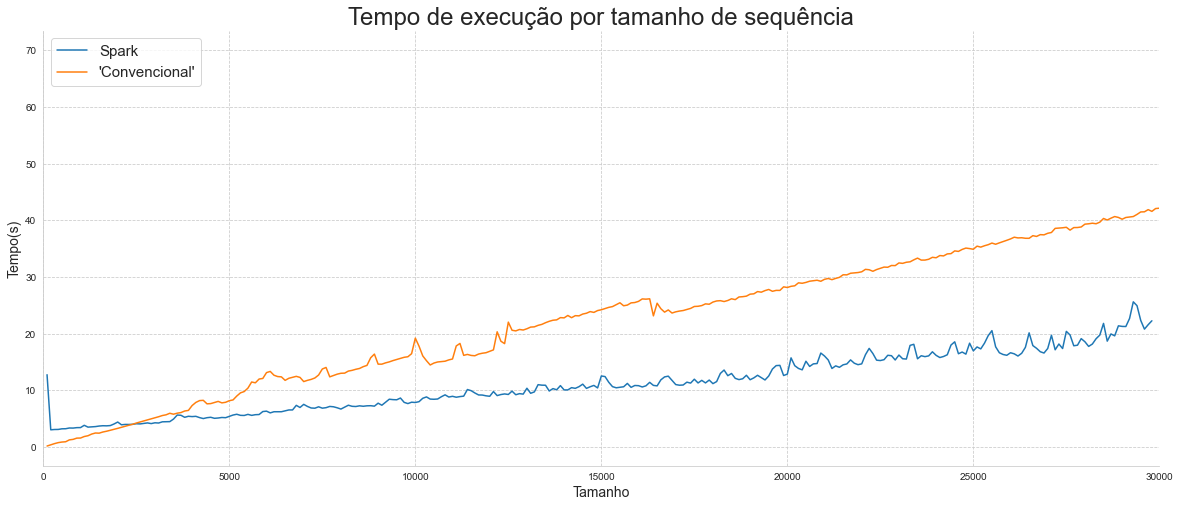

In [34]:
# Gero os gráficos com o resultado
import seaborn as sns
sns.set_style("whitegrid", {'grid.linestyle': '--'})
fig, ax = plt.subplots(figsize=(20,8))
# sns.lineplot(x="Size", y="Spark", data=sprDf, ax=ax)
sns.lineplot(data=dataDf, x='Size', y='Time', hue='Tipo', ax=ax)

maxSpr, maxTrad = dataDf.groupby('Tipo').Time.max()
nthSpr, nthTrad = dataDf.groupby('Tipo').Time.nth(-1)

# Aestetic
ax.set_title("Tempo de execução por tamanho de sequência", fontdict={'fontsize':24})
ax.set_xlabel('Tamanho', fontdict={'fontsize':14})
ax.set_ylabel('Tempo(s)', fontdict={'fontsize':14})
ax.set(xlim=[0, 30000])
ax.legend(["Spark", "'Convencional'"], frameon=True, fontsize=15, loc='upper left')
sns.despine(ax=ax)
plt.show()